In [1]:
import onnxruntime
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from utils import *

# Download/Convert the model

You can either download a pre-trained model already in `onnx` or train/convert a model. For more information check [here](https://github.com/Megvii-BaseDetection/YOLOX/tree/main/demo/ONNXRuntime)

# Configuring the inputs

In [2]:
model_path = 'models/yolox_s.onnx' #Model path: https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_s.onnx
input_shape = (640, 640) # Must match model input shape during onnx conversion
image_path = 'dummy_dataset/zidane.jpg' # Input image path
output_dir = 'dummy_dataset/results' # Output image path
with_p6 = False # Whether your model uses p6 in FPN/PAN
score_thr = 0.3

# Loading the model

In [3]:
session = onnxruntime.InferenceSession(model_path)

# Loading the input image and preprocessing it

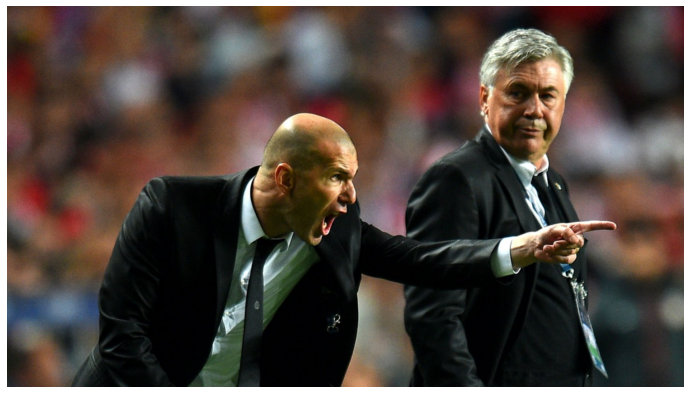

In [4]:
origin_img = cv2.imread(image_path)
img, ratio = preprocess(origin_img, input_shape)
ort_inputs = {session.get_inputs()[0].name: img[None, :, :, :]}

plt.figure(figsize=(14,7))
plt.imshow(cv2.cvtColor(origin_img, cv2.COLOR_RGB2BGR))
plt.axis('off');

# Runing Inference

In [5]:
output = session.run(None, ort_inputs)
predictions = postprocess(output[0], input_shape, p6=with_p6)[0]
predictions.shape #[n_detections, (bbox + conf)]

(8400, 85)

In [6]:
boxes = predictions[:, :4]
scores = predictions[:, 4:5] * predictions[:, 5:]
boxes_xyxy = xywh_to_xyxy(boxes, ratio)

In [7]:
boxes_xyxy.shape, scores.shape # ([n_det, (x0, y0, x1, y1)], [n_det, num_classes])

((8400, 4), (8400, 80))

In [8]:
dets = multiclass_nms(boxes_xyxy, scores, nms_thr=0.45, score_thr=0.1)
dets.shape # [n_det, (x0, y0, x1, y1, conf, class)]

(7, 6)

In [9]:
if dets is not None:
    final_boxes, final_scores, final_cls_inds = dets[:, :4], dets[:, 4], dets[:, 5]
    origin_img = vis(origin_img, final_boxes, final_scores, final_cls_inds,
                        conf=score_thr, class_names=COCO_CLASSES)

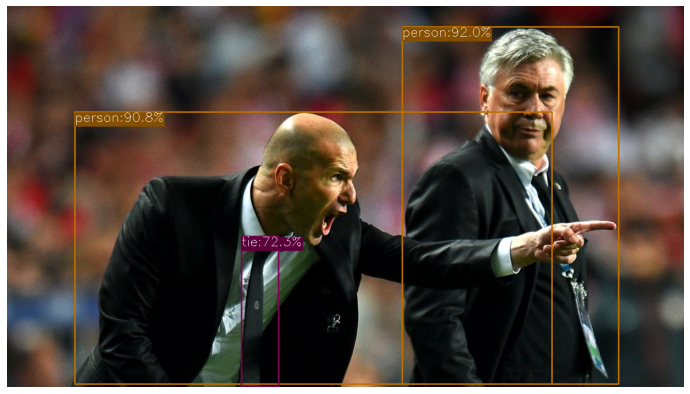

In [10]:
plt.figure(figsize=(14,7))
plt.imshow(cv2.cvtColor(origin_img, cv2.COLOR_RGB2BGR))
plt.axis('off');

In [11]:
os.makedirs(output_dir, exist_ok = True)
output_path = os.path.join(output_dir, os.path.basename(image_path))
cv2.imwrite(output_path, origin_img)

True